In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import scipy.interpolate

import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 7
mpl.rcParams['svg.fonttype'] = 'none'

In [3]:
DtoP = np.load('spinePopModels/transition_mats/DtoP_transition_matrix.npy')
PtoE = np.load('spinePopModels/transition_mats/PtoE_transition_matrix.npy')
EtoM = np.load('spinePopModels/transition_mats/EtoM_transition_matrix.npy')
MtoD = np.load('spinePopModels/transition_mats/MtoD_transition_matrix.npy')

In [72]:
DtoP.round(4)

array([[0.5174, 0.2121, 0.1189, 0.1549, 0.0905],
       [0.0269, 0.0909, 0.0559, 0.0075, 0.0329],
       [0.1756, 0.3939, 0.4406, 0.166 , 0.2305],
       [0.2215, 0.1818, 0.2657, 0.5466, 0.214 ],
       [0.0585, 0.1212, 0.1189, 0.125 , 0.4321]])

In [4]:
symbol_matrix = np.array([
    [r'$\delta_M$', r'$\gamma_{M \to F}$', r'$\gamma_{M \to H}$', r'$\gamma_{M \to S}$', r'$-\lambda_M$'],
    [r'$\delta_S$', r'$\gamma_{S \to F}$', r'$\gamma_{S \to H}$', r'$-\lambda_S$', r'$\gamma_{S \to M}$'],
    [r'$\delta_H$', r'$\gamma_{H \to F}$', r'$-\lambda_H$', r'$\gamma_{H \to S}$', r'$\gamma_{H \to M}$'],
    [r'$\delta_F$', r'$-\lambda_F$', r'$\gamma_{F \to H}$', r'$\gamma_{F \to S}$', r'$\gamma_{F \to M}$'],
    [r'$0$', r'$\beta_F$', r'$\beta_H$', r'$\beta_S$', r'$\beta_M$']
])

In [7]:
for i in range(5):
    for j in range(5):
        if 'lambda' not in symbol_matrix[i,j] and symbol_matrix[i,j] != '$0$':
            print(symbol_matrix[i,j], '=', DtoP[i,j])

$\delta_M$ = 0.5174050632911392
$\gamma_{M \to F}$ = 0.21212121212121213
$\gamma_{M \to H}$ = 0.11888111888111888
$\gamma_{M \to S}$ = 0.15485074626865672
$\delta_S$ = 0.02689873417721519
$\gamma_{S \to F}$ = 0.09090909090909091
$\gamma_{S \to H}$ = 0.055944055944055944
$\gamma_{S \to M}$ = 0.03292181069958848
$\delta_H$ = 0.17563291139240506
$\gamma_{H \to F}$ = 0.3939393939393939
$\gamma_{H \to S}$ = 0.166044776119403
$\gamma_{H \to M}$ = 0.23045267489711935
$\delta_F$ = 0.22151898734177214
$\gamma_{F \to H}$ = 0.26573426573426573
$\gamma_{F \to S}$ = 0.5466417910447762
$\gamma_{F \to M}$ = 0.2139917695473251
$\beta_F$ = 0.12121212121212122
$\beta_H$ = 0.11888111888111888
$\beta_S$ = 0.125
$\beta_M$ = 0.43209876543209874


In [5]:
def compute_C_from_P(P):

    P = np.array(P, dtype=float)
    
    # Extract the 4x4 submatrix (rows 0-3, cols 1-4) which contains the gamma parameters (off-diagonal)
    # Diagonal deltas are in P[i, i] (0 to 3)
    # We'll build a 4x4 matrix of gammas, with diagonal zeros.
    
    A = np.zeros((4,4))
    
    for i in range(4):
        delta_i = P[i, i]          # diagonal delta
        # gamma params in row i, columns 1 to 4 (index 1 to 4)
        # but only columns 1 to 4, excluding diagonal column i
        # diagonal in terms of gammas: we want to skip P[i, i] but i and column indices don't align because gamma start at col 1
        # So build row gamma vector (cols 1 to 4)
        gamma_row = P[i, 1:5]  # length 4
        
        # The diagonal of A corresponds to gamma_row element where col = i
        # Because for i=0 -> skip gamma_row[0], i=1 -> skip gamma_row[1], etc.
        denom = delta_i + np.sum(np.delete(gamma_row, i))
        
        for j in range(4):
            if j == i:
                A[i,j] = 0.0
            else:
                A[i,j] = gamma_row[j] / denom

    beta_F = P[4, 1]
    beta_H = P[4, 2]
    beta_S = P[4, 3]
    beta_M = P[4, 4]
    
    # Order: [M, S, H, F]
    B = np.array([beta_M, beta_S, beta_H, beta_F])
    
    return A, B



In [15]:

A, B = compute_C_from_P(MtoD)
print(A.round(4))
print(B.round(4))


[[0.     0.1532 0.149  0.1079]
 [0.4094 0.     0.0383 0.1429]
 [0.2486 0.3034 0.     0.1446]
 [0.0718 0.1787 0.3748 0.    ]]
[0.4152 0.1226 0.1591 0.1724]


In [16]:
np.linalg.inv(np.eye(4)-A)@B

array([0.61893264, 0.46726111, 0.52668486, 0.49770504])

In [17]:
x = np.linalg.solve((np.eye(4)-A), B)
print("Equilibrium values:")
print(f"F* = {x[0]:.4f}")
print(f"H* = {x[1]:.4f}")
print(f"S* = {x[2]:.4f}")
print(f"M* = {x[3]:.4f}")

Equilibrium values:
F* = 0.6189
H* = 0.4673
S* = 0.5267
M* = 0.4977


In [18]:
def compute_jacobian(P):
    # Unpack parameters from matrix P
    delta_M = P[0, 0]
    gamma_M_to_F = P[0, 1]
    gamma_M_to_H = P[0, 2]
    gamma_M_to_S = P[0, 3]

    delta_S = P[1, 0]
    gamma_S_to_F = P[1, 1]
    gamma_S_to_H = P[1, 2]
    gamma_S_to_M = P[1, 4]

    delta_H = P[2, 0]
    gamma_H_to_F = P[2, 1]
    gamma_H_to_S = P[2, 3]
    gamma_H_to_M = P[2, 4]

    delta_F = P[3, 0]
    gamma_F_to_H = P[3, 2]
    gamma_F_to_S = P[3, 3]
    gamma_F_to_M = P[3, 4]

    # Denominator terms for each row
    D_F = delta_F + gamma_F_to_H + gamma_F_to_S + gamma_F_to_M
    D_H = delta_H + gamma_H_to_F + gamma_H_to_S + gamma_H_to_M
    D_S = delta_S + gamma_S_to_F + gamma_S_to_H + gamma_S_to_M
    D_M = delta_M + gamma_M_to_F + gamma_M_to_H + gamma_M_to_S

    # Build Jacobian matrix
    J = np.array([
        [-1,                gamma_H_to_F / D_F, gamma_S_to_F / D_F, gamma_M_to_F / D_F],  # dF/d*
        [gamma_F_to_H / D_H, -1,                gamma_S_to_H / D_H, gamma_M_to_H / D_H],  # dH/d*
        [gamma_F_to_S / D_S, gamma_H_to_S / D_S, -1,                gamma_M_to_S / D_S],  # dS/d*
        [gamma_F_to_M / D_M, gamma_H_to_M / D_M, gamma_S_to_M / D_M, -1]                 # dM/d*
    ])

    return J

In [ ]:
J = compute_jacobian(DtoP)
J.round(4)

array([[-1.    ,  0.3157,  0.0729,  0.17  ],
       [ 0.2751, -1.    ,  0.0579,  0.1231],
       [ 2.645 ,  0.8034, -1.    ,  0.7493],
       [ 0.2133,  0.2297,  0.0328, -1.    ]])

In [31]:
eigenvalues, eigenvectors = np.linalg.eig(J)
print('vals:')
print(eigenvalues.round(4))
print('vecs:')
for i in range(4):
    print(eigenvectors[:,i].round(4))

vals:
[-0.2313 -1.4147 -1.2259 -1.1281]
vecs:
[-0.1889 -0.1625 -0.958  -0.1419]
[-0.1472 -0.0473  0.9877  0.0238]
[-0.0501 -0.2914  0.9323  0.2082]
[-0.1212 -0.2483 -0.5499  0.7882]


In [67]:
def plot_phase_portrait(P, init_conditions, plot_vars=['F', 'H'], ax=None):
    # Extract parameters from P matrix
    delta_M, gMF, gMH, gMS = P[0, 0], P[0, 1], P[0, 2], P[0, 3]
    delta_S, gSF, gSH, gSM = P[1, 0], P[1, 1], P[1, 2], P[1, 4]
    delta_H, gHF, gHS, gHM = P[2, 0], P[2, 1], P[2, 3], P[2, 4]
    delta_F, gFH, gFS, gFM = P[3, 0], P[3, 2], P[3, 3], P[3, 4]
    beta_F, beta_H, beta_S, beta_M = P[4, 1], P[4, 2], P[4, 3], P[4, 4]

    # Variable mapping
    var_idx = {'F': 0, 'H': 1, 'S': 2, 'M': 3}
    all_vars = ['F', 'H', 'S', 'M']

    # Determine free and fixed variables
    free_vars = plot_vars
    fixed_vars = [v for v in all_vars if v not in free_vars]

    # Generate grid for free variables
    grid_size = 10
    v1_vals = np.linspace(0, 20, grid_size)
    v2_vals = np.linspace(0, 20, grid_size)
    V1, V2 = np.meshgrid(v1_vals, v2_vals)

    # Initialize derivative arrays
    dV1 = np.zeros_like(V1)
    dV2 = np.zeros_like(V2)

    # Loop over grid points
    for i in range(grid_size):
        for j in range(grid_size):
            # Initialize full state vector from initial conditions
            state = init_conditions.copy()
            state[var_idx[free_vars[0]]] = V1[i, j]
            state[var_idx[free_vars[1]]] = V2[i, j]

            F, H, S, M = state

            # Compute time derivatives (df/dt, etc.)
            dF = beta_F - delta_F * F + gHF * H + gSF * S + gMF * M - F * (gFH + gFS + gFM)
            dH = beta_H - delta_H * H + gFH * F + gSH * S + gMH * M - H * (gHF + gHS + gHM)
            dS = beta_S - delta_S * S + gFS * F + gHS * H + gMS * M - S * (gSF + gSH + gSM)
            dM = beta_M - delta_M * M + gFM * F + gHM * H + gSM * S - M * (gMF + gMH + gMS)

            derivatives = [dF, dH, dS, dM]

            dV1[i, j] = derivatives[var_idx[free_vars[0]]]
            dV2[i, j] = derivatives[var_idx[free_vars[1]]]

    # Normalize vectors for quiver plot
    magnitude = np.sqrt(dV1**2 + dV2**2)
    dV1 /= (magnitude + 1e-8)
    dV2 /= (magnitude + 1e-8)

    J = compute_jacobian(P)
    eigvals, eigvecs = np.linalg.eig(J)

    if ax is None:
        fig, ax = plt.subplots(1, 1, dpi=300, figsize=(3,3))

    # t = np.linspace(0, 40, 1000)
    # for i in range(2):
    #     lam = eigvals[i]
    #     v = eigvecs[:, i]
    #     for alpha in [-2, -1, 1, 2]:
    #         traj = np.outer(np.exp(lam * t), alpha * v)
    #         plt.plot(traj[:, 0], traj[:, 1], 'r', lw=1)

    ax.quiver(V1, V2, dV1, dV2, angles='xy')
    ax.set_xlabel(free_vars[0])
    ax.set_ylabel(free_vars[1])
    ax.set_xlim([0,20])
    ax.set_ylim([0,20])
    ax.axis('equal')
    # plt.title(f'Phase Portrait: {free_vars[0]} vs {free_vars[1]} (others fixed)')
    plt.tight_layout()


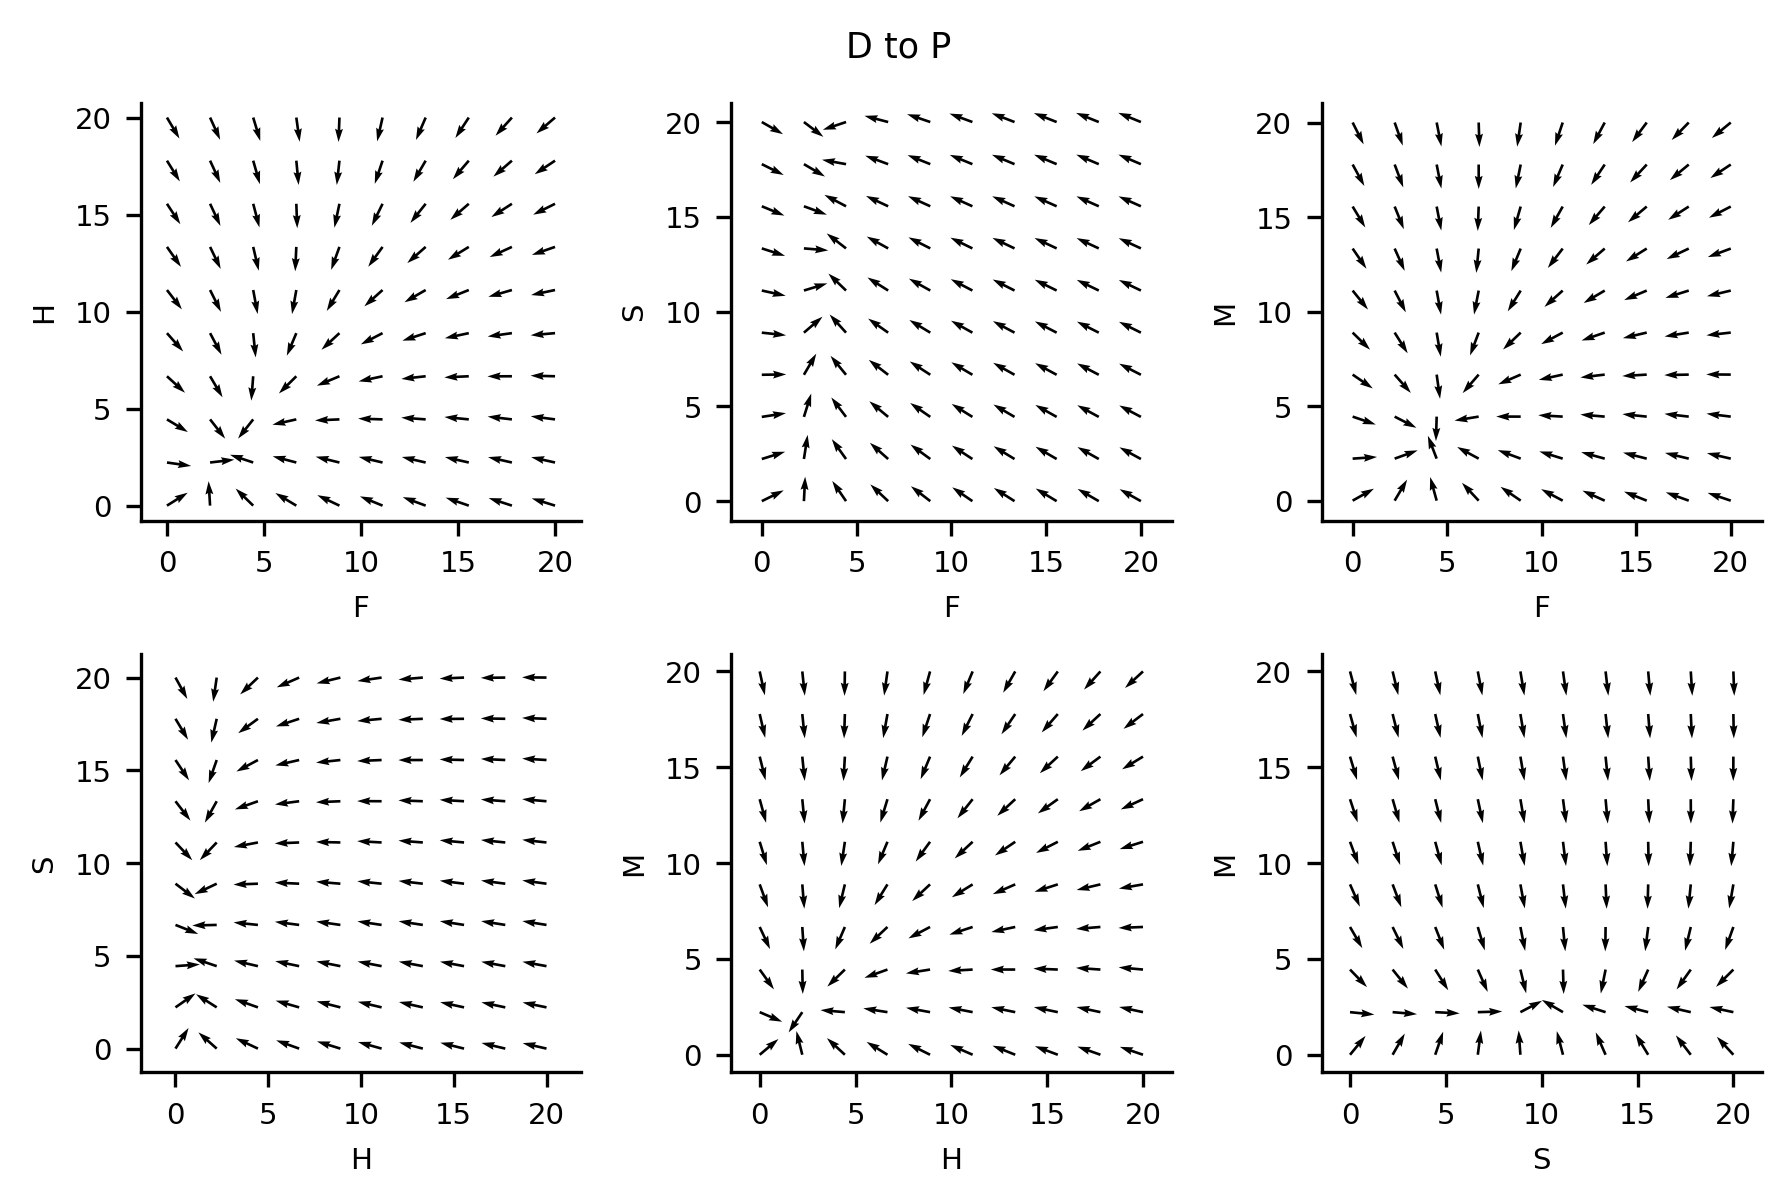

In [68]:
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2, 3, figsize=(6,4), dpi=300)

plot_phase_portrait(DtoP, [1,6,23,2], ['F','H'], ax=ax1)
plot_phase_portrait(DtoP, [1,6,23,2], ['F','S'], ax=ax2)
plot_phase_portrait(DtoP, [1,6,23,2], ['F','M'], ax=ax3)
plot_phase_portrait(DtoP, [1,6,23,2], ['H','S'], ax=ax4)
plot_phase_portrait(DtoP, [1,6,23,2], ['H','M'], ax=ax5)
plot_phase_portrait(DtoP, [1,6,23,2], ['S','M'], ax=ax6)

fig.suptitle('D to P')
fig.tight_layout()
fig.savefig('DtoP_vecfields.svg')

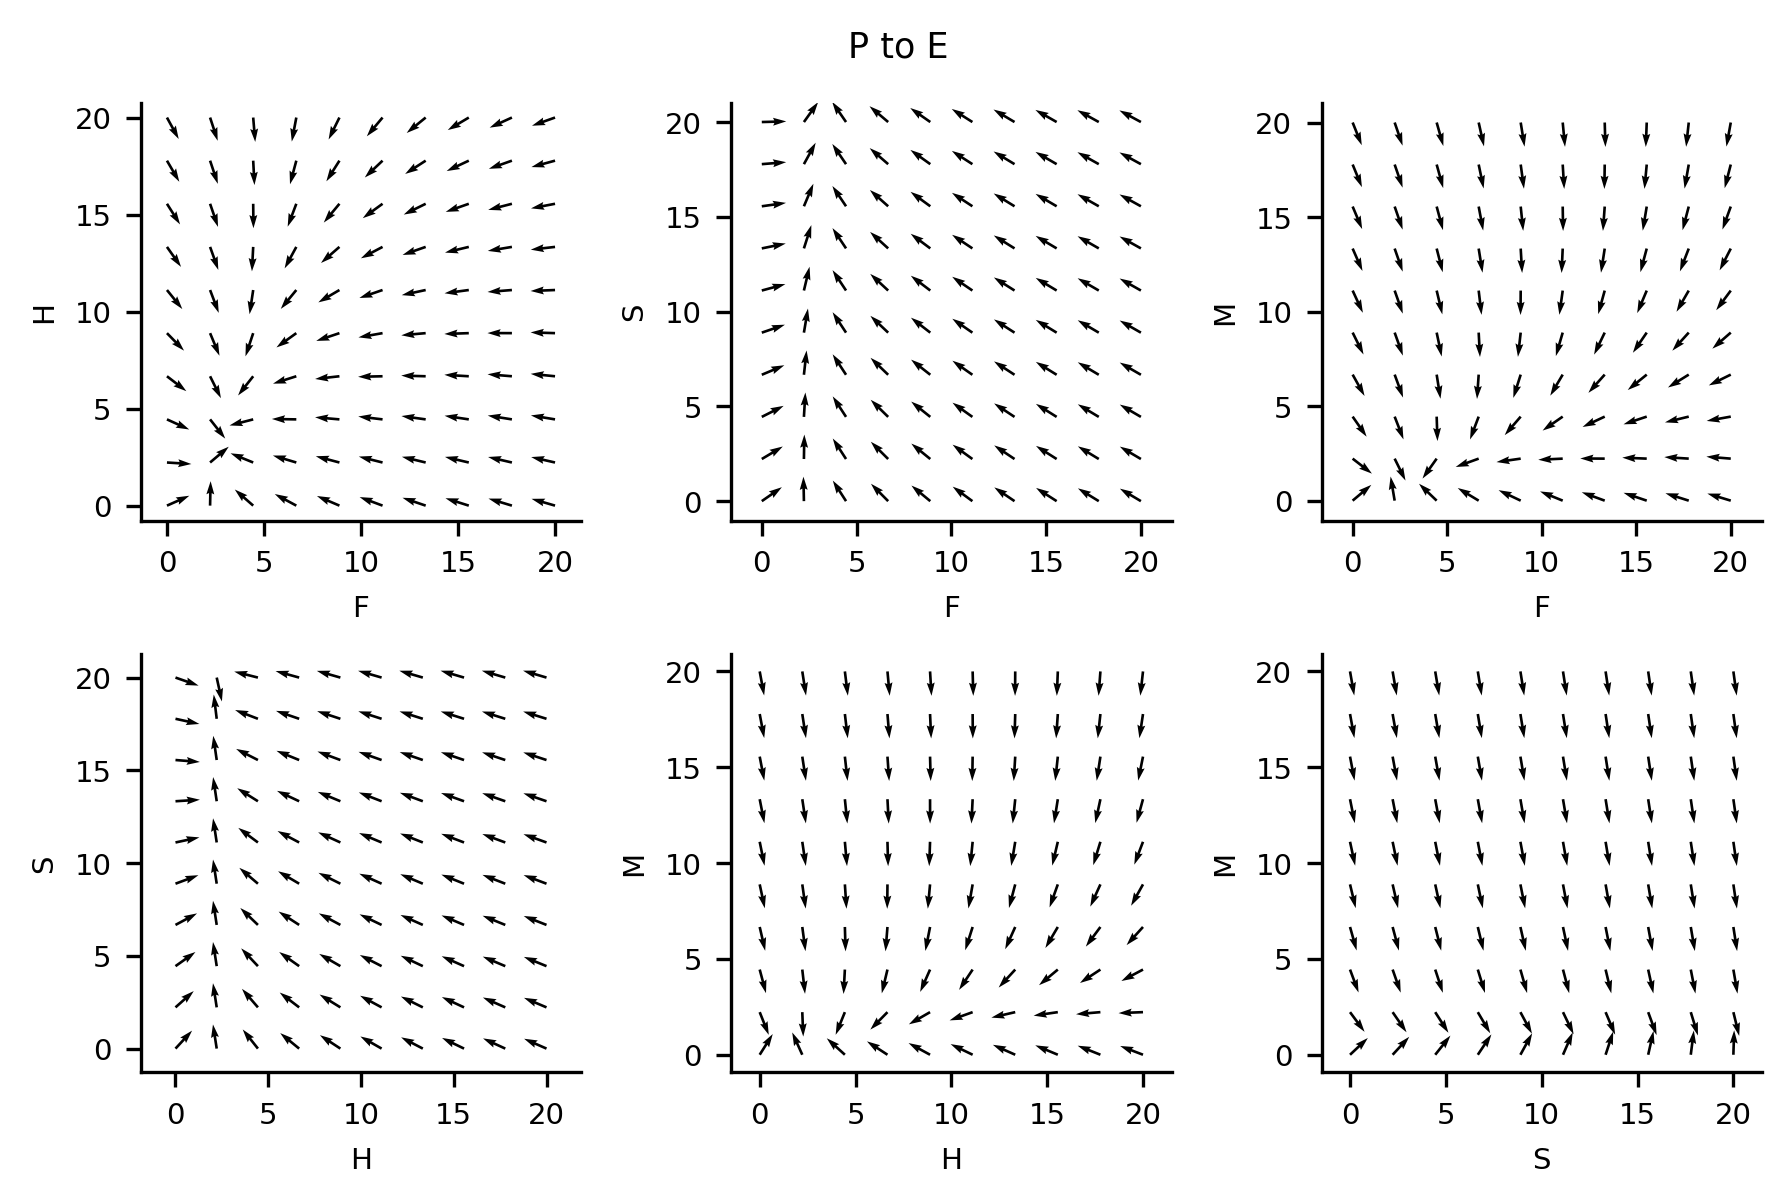

In [69]:
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2, 3, figsize=(6,4), dpi=300)

plot_phase_portrait(PtoE, [1,6,23,2], ['F','H'], ax=ax1)
plot_phase_portrait(PtoE, [1,6,23,2], ['F','S'], ax=ax2)
plot_phase_portrait(PtoE, [1,6,23,2], ['F','M'], ax=ax3)
plot_phase_portrait(PtoE, [1,6,23,2], ['H','S'], ax=ax4)
plot_phase_portrait(PtoE, [1,6,23,2], ['H','M'], ax=ax5)
plot_phase_portrait(PtoE, [1,6,23,2], ['S','M'], ax=ax6)

fig.suptitle('P to E')
fig.tight_layout()
fig.savefig('PtoE_vecfields.svg')

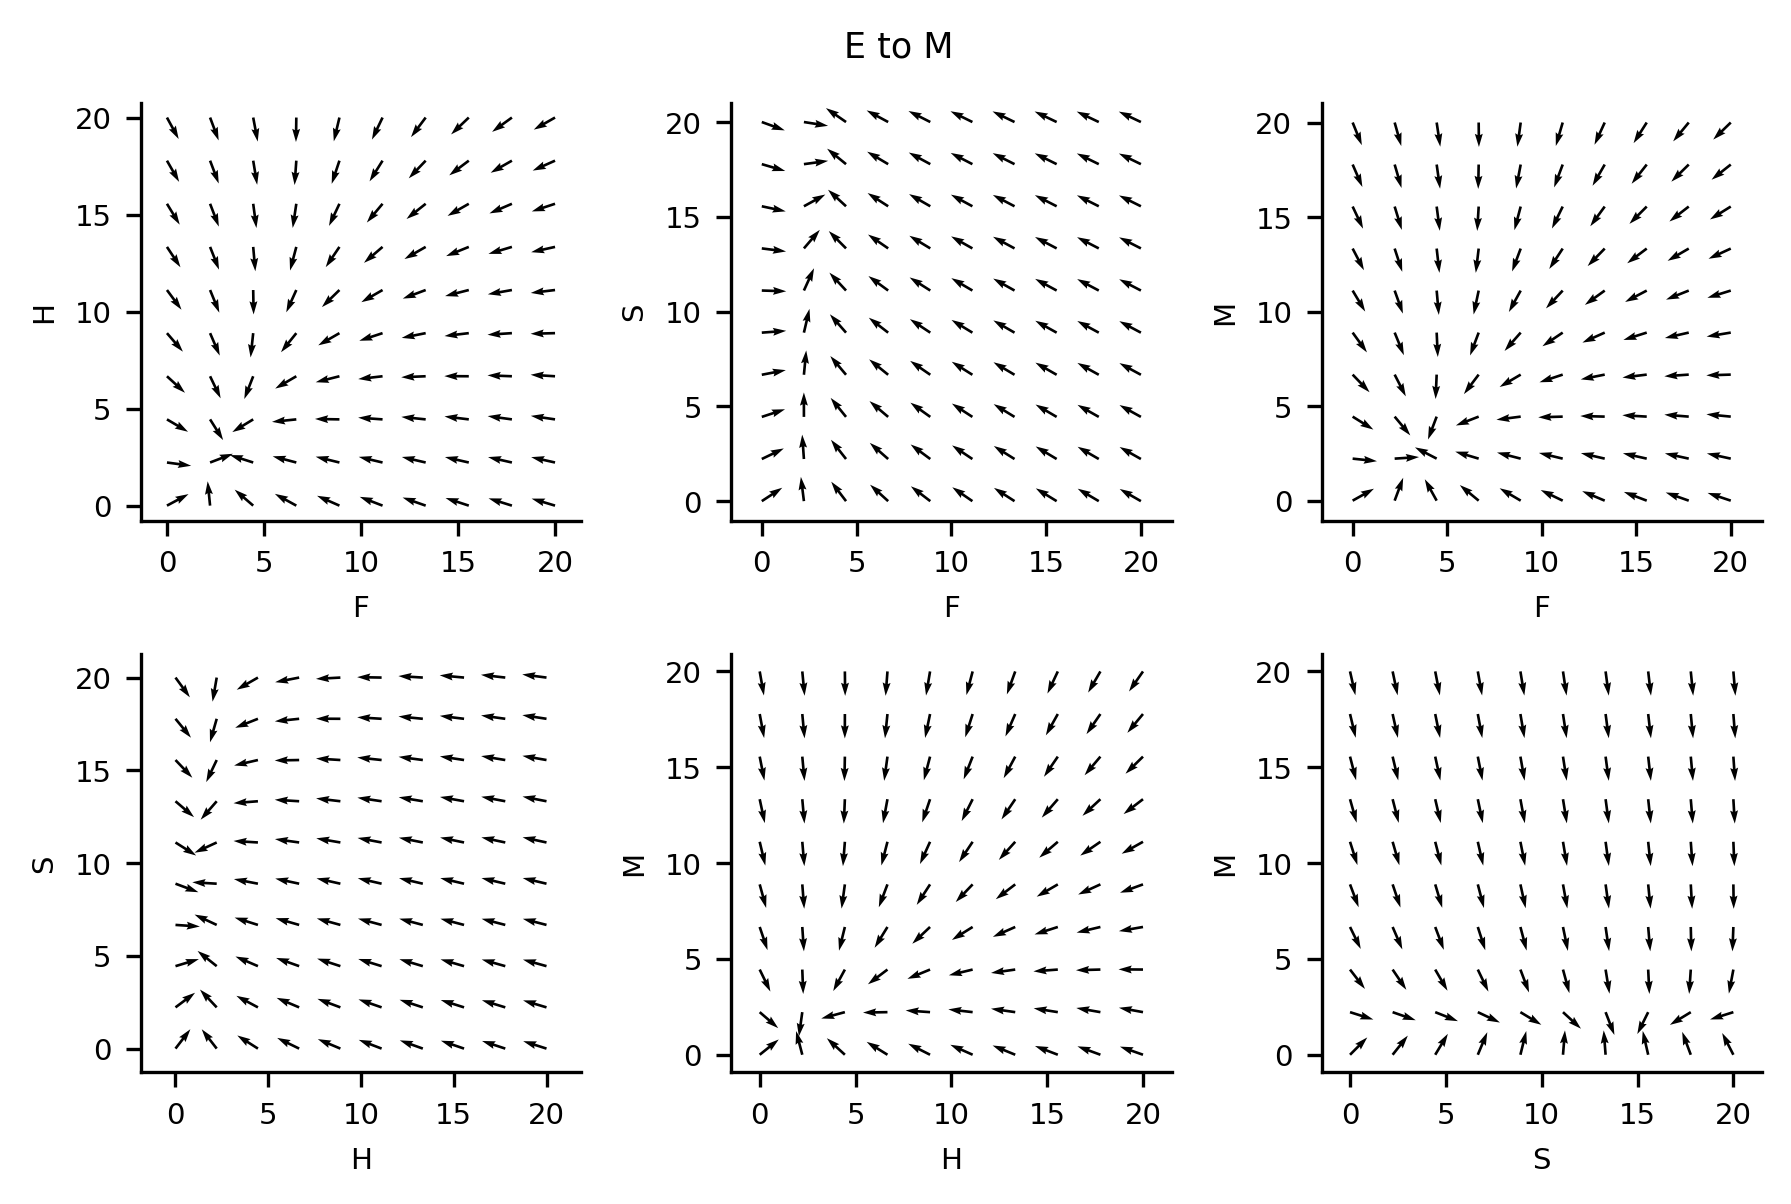

In [70]:
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2, 3, figsize=(6,4), dpi=300)

plot_phase_portrait(EtoM, [1,6,23,2], ['F','H'], ax=ax1)
plot_phase_portrait(EtoM, [1,6,23,2], ['F','S'], ax=ax2)
plot_phase_portrait(EtoM, [1,6,23,2], ['F','M'], ax=ax3)
plot_phase_portrait(EtoM, [1,6,23,2], ['H','S'], ax=ax4)
plot_phase_portrait(EtoM, [1,6,23,2], ['H','M'], ax=ax5)
plot_phase_portrait(EtoM, [1,6,23,2], ['S','M'], ax=ax6)

fig.suptitle('E to M')
fig.tight_layout()
fig.savefig('EtoM_vecfields.svg')

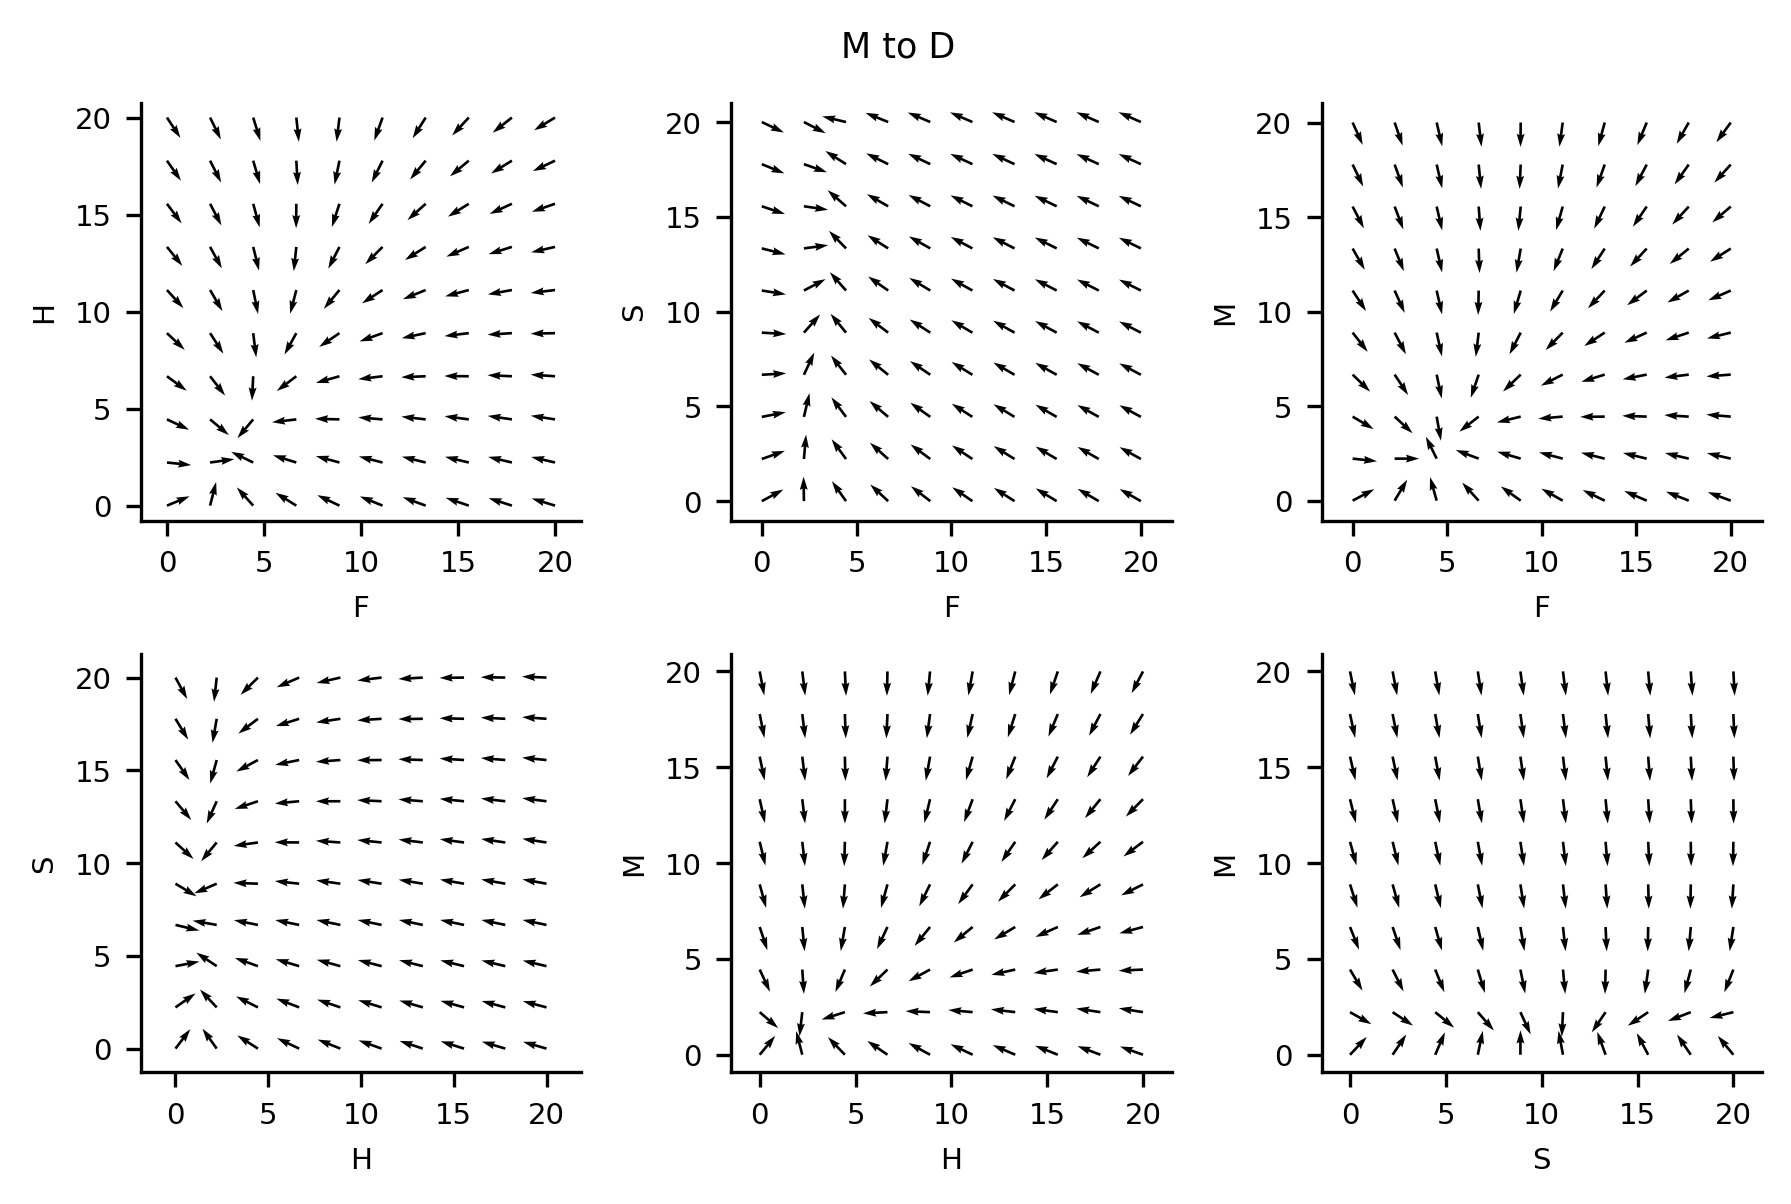

In [71]:
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2, 3, figsize=(6,4), dpi=300)

plot_phase_portrait(MtoD, [1,6,23,2], ['F','H'], ax=ax1)
plot_phase_portrait(MtoD, [1,6,23,2], ['F','S'], ax=ax2)
plot_phase_portrait(MtoD, [1,6,23,2], ['F','M'], ax=ax3)
plot_phase_portrait(MtoD, [1,6,23,2], ['H','S'], ax=ax4)
plot_phase_portrait(MtoD, [1,6,23,2], ['H','M'], ax=ax5)
plot_phase_portrait(MtoD, [1,6,23,2], ['S','M'], ax=ax6)

fig.suptitle('M to D')
fig.tight_layout()
fig.savefig('MtoD_vecfields.svg')

In [105]:
from scipy.integrate import solve_ivp

def simulate_system(P, y0=None, t_steps=16):
    # t step is in # samples

    # Parameter unpacking from matrix P
    delta_F = P[3, 0]
    delta_H = P[2, 0]
    delta_S = P[1, 0]
    delta_M = P[0, 0]
    
    gamma_FH = P[3, 2]
    gamma_FS = P[3, 3]
    gamma_FM = P[3, 4]

    gamma_HF = P[2, 1]
    gamma_HS = P[2, 3]
    gamma_HM = P[2, 4]

    gamma_SF = P[1, 1]
    gamma_SH = P[1, 2]
    gamma_SM = P[1, 4]

    gamma_MF = P[0, 1]
    gamma_MH = P[0, 2]
    gamma_MS = P[0, 3]

    beta_F = P[4, 1]
    beta_H = P[4, 2]
    beta_S = P[4, 3]
    beta_M = P[4, 4]

    # Default initial conditions if not provided
    if y0 is None:
        y0 = [0.2, 0.1, 0.3, 0.4]  # F, H, S, M

    # ODE system
    def system(t, y):
        F, H, S, M = y

        D_F = delta_F + gamma_FH + gamma_FS + gamma_FM
        D_H = delta_H + gamma_HF + gamma_HS + gamma_HM
        D_S = delta_S + gamma_SF + gamma_SH + gamma_SM
        D_M = delta_M + gamma_MF + gamma_MH + gamma_MS

        dFdt = (beta_F + gamma_HF * H + gamma_SF * S + gamma_MF * M) / D_F - F
        dHdt = (beta_H + gamma_FH * F + gamma_SH * S + gamma_MH * M) / D_H - H
        dSdt = (beta_S + gamma_FS * F + gamma_HS * H + gamma_MS * M) / D_S - S
        dMdt = (beta_M + gamma_FM * F + gamma_HM * H + gamma_SM * S) / D_M - M

        return [dFdt, dHdt, dSdt, dMdt]

    # Time evaluation points
    t_eval = np.arange(0, t_steps)*12

    # Solve the ODE system
    sol = solve_ivp(system, [0, t_steps*12], y0, t_eval=t_eval)
    return sol


In [61]:
import pandas as pd
import os

In [64]:
file_paths = sorted([x for x in os.listdir('./clean_data') if '.h5' in x])
file_paths, len(file_paths)

(['NSW007_1_data.h5',
  'NSW007_2_data.h5',
  'NSW007_3_data.h5',
  'NSW008_1_data.h5',
  'NSW008_2_data.h5',
  'NSW008_3_data.h5',
  'WTR041_1_data.h5',
  'WTR041_2_data.h5',
  'WTR041_3_data.h5',
  'WTR041_4_data.h5',
  'WTR042_1_data.h5',
  'WTR042_2_data.h5',
  'WTR042_3_data.h5',
  'WTR042_4_data.h5',
  'WTR042_5_data.h5',
  'WTR051_1_data.h5',
  'WTR051_2_data.h5',
  'WTR051_3_data.h5',
  'WTR052_1_data.h5',
  'WTR052_2_data.h5',
  'WTR052_3_data.h5'],
 21)

In [70]:
df

,spine_00,spine_01,spine_02,spine_03,spine_04,spine_05,spine_06,spine_07,spine_08,spine_09,...,spine_33,spine_34,spine_35,spine_36,spine_37,spine_38,spine_39,spine_40,hrs,stage
0,thin,thin,filopodium,thin,stubby,thin,thin,thin,mushroom,thin,...,stubby,thin,NS,NS,NS,NS,NS,NS,0,P
1,stubby,stubby,stubby,stubby,thin,mushroom,thin,stubby,NS,thin,...,mushroom,stubby,mushroom,stubby,mushroom,thin,NS,stubby,12,P
2,stubby,stubby,stubby,thin,thin,thin,thin,stubby,thin,stubby,...,stubby,stubby,filopodium,thin,stubby,NS,NS,thin,24,E
3,NS,NS,thin,filopodium,stubby,mushroom,thin,NS,thin,thin,...,NS,mushroom,NS,stubby,mushroom,NS,NS,stubby,36,E
4,thin,mushroom,stubby,stubby,filopodium,mushroom,thin,thin,NS,thin,...,NS,stubby,NS,thin,stubby,NS,mushroom,thin,48,E
5,stubby,thin,stubby,thin,stubby,thin,thin,thin,NS,thin,...,NS,stubby,NS,thin,thin,NS,NS,stubby,60,E
6,stubby,mushroom,stubby,NS,stubby,NS,stubby,stubby,NS,thin,...,NS,mushroom,NS,thin,mushroom,NS,NS,stubby,72,E
7,stubby,NS,stubby,stubby,thin,thin,thin,thin,thin,thin,...,stubby,stubby,NS,stubby,mushroom,thin,thin,stubby,84,M
8,stubby,stubby,thin,thin,mushroom,mushroom,stubby,thin,stubby,NS,...,thin,stubby,thin,mushroom,mushroom,NS,NS,thin,96,D
9,stubby,stubby,stubby,stubby,stubby,stubby,thin,thin,thin,NS,...,thin,stubby,mushroom,thin,thin,NS,NS,thin,108,D


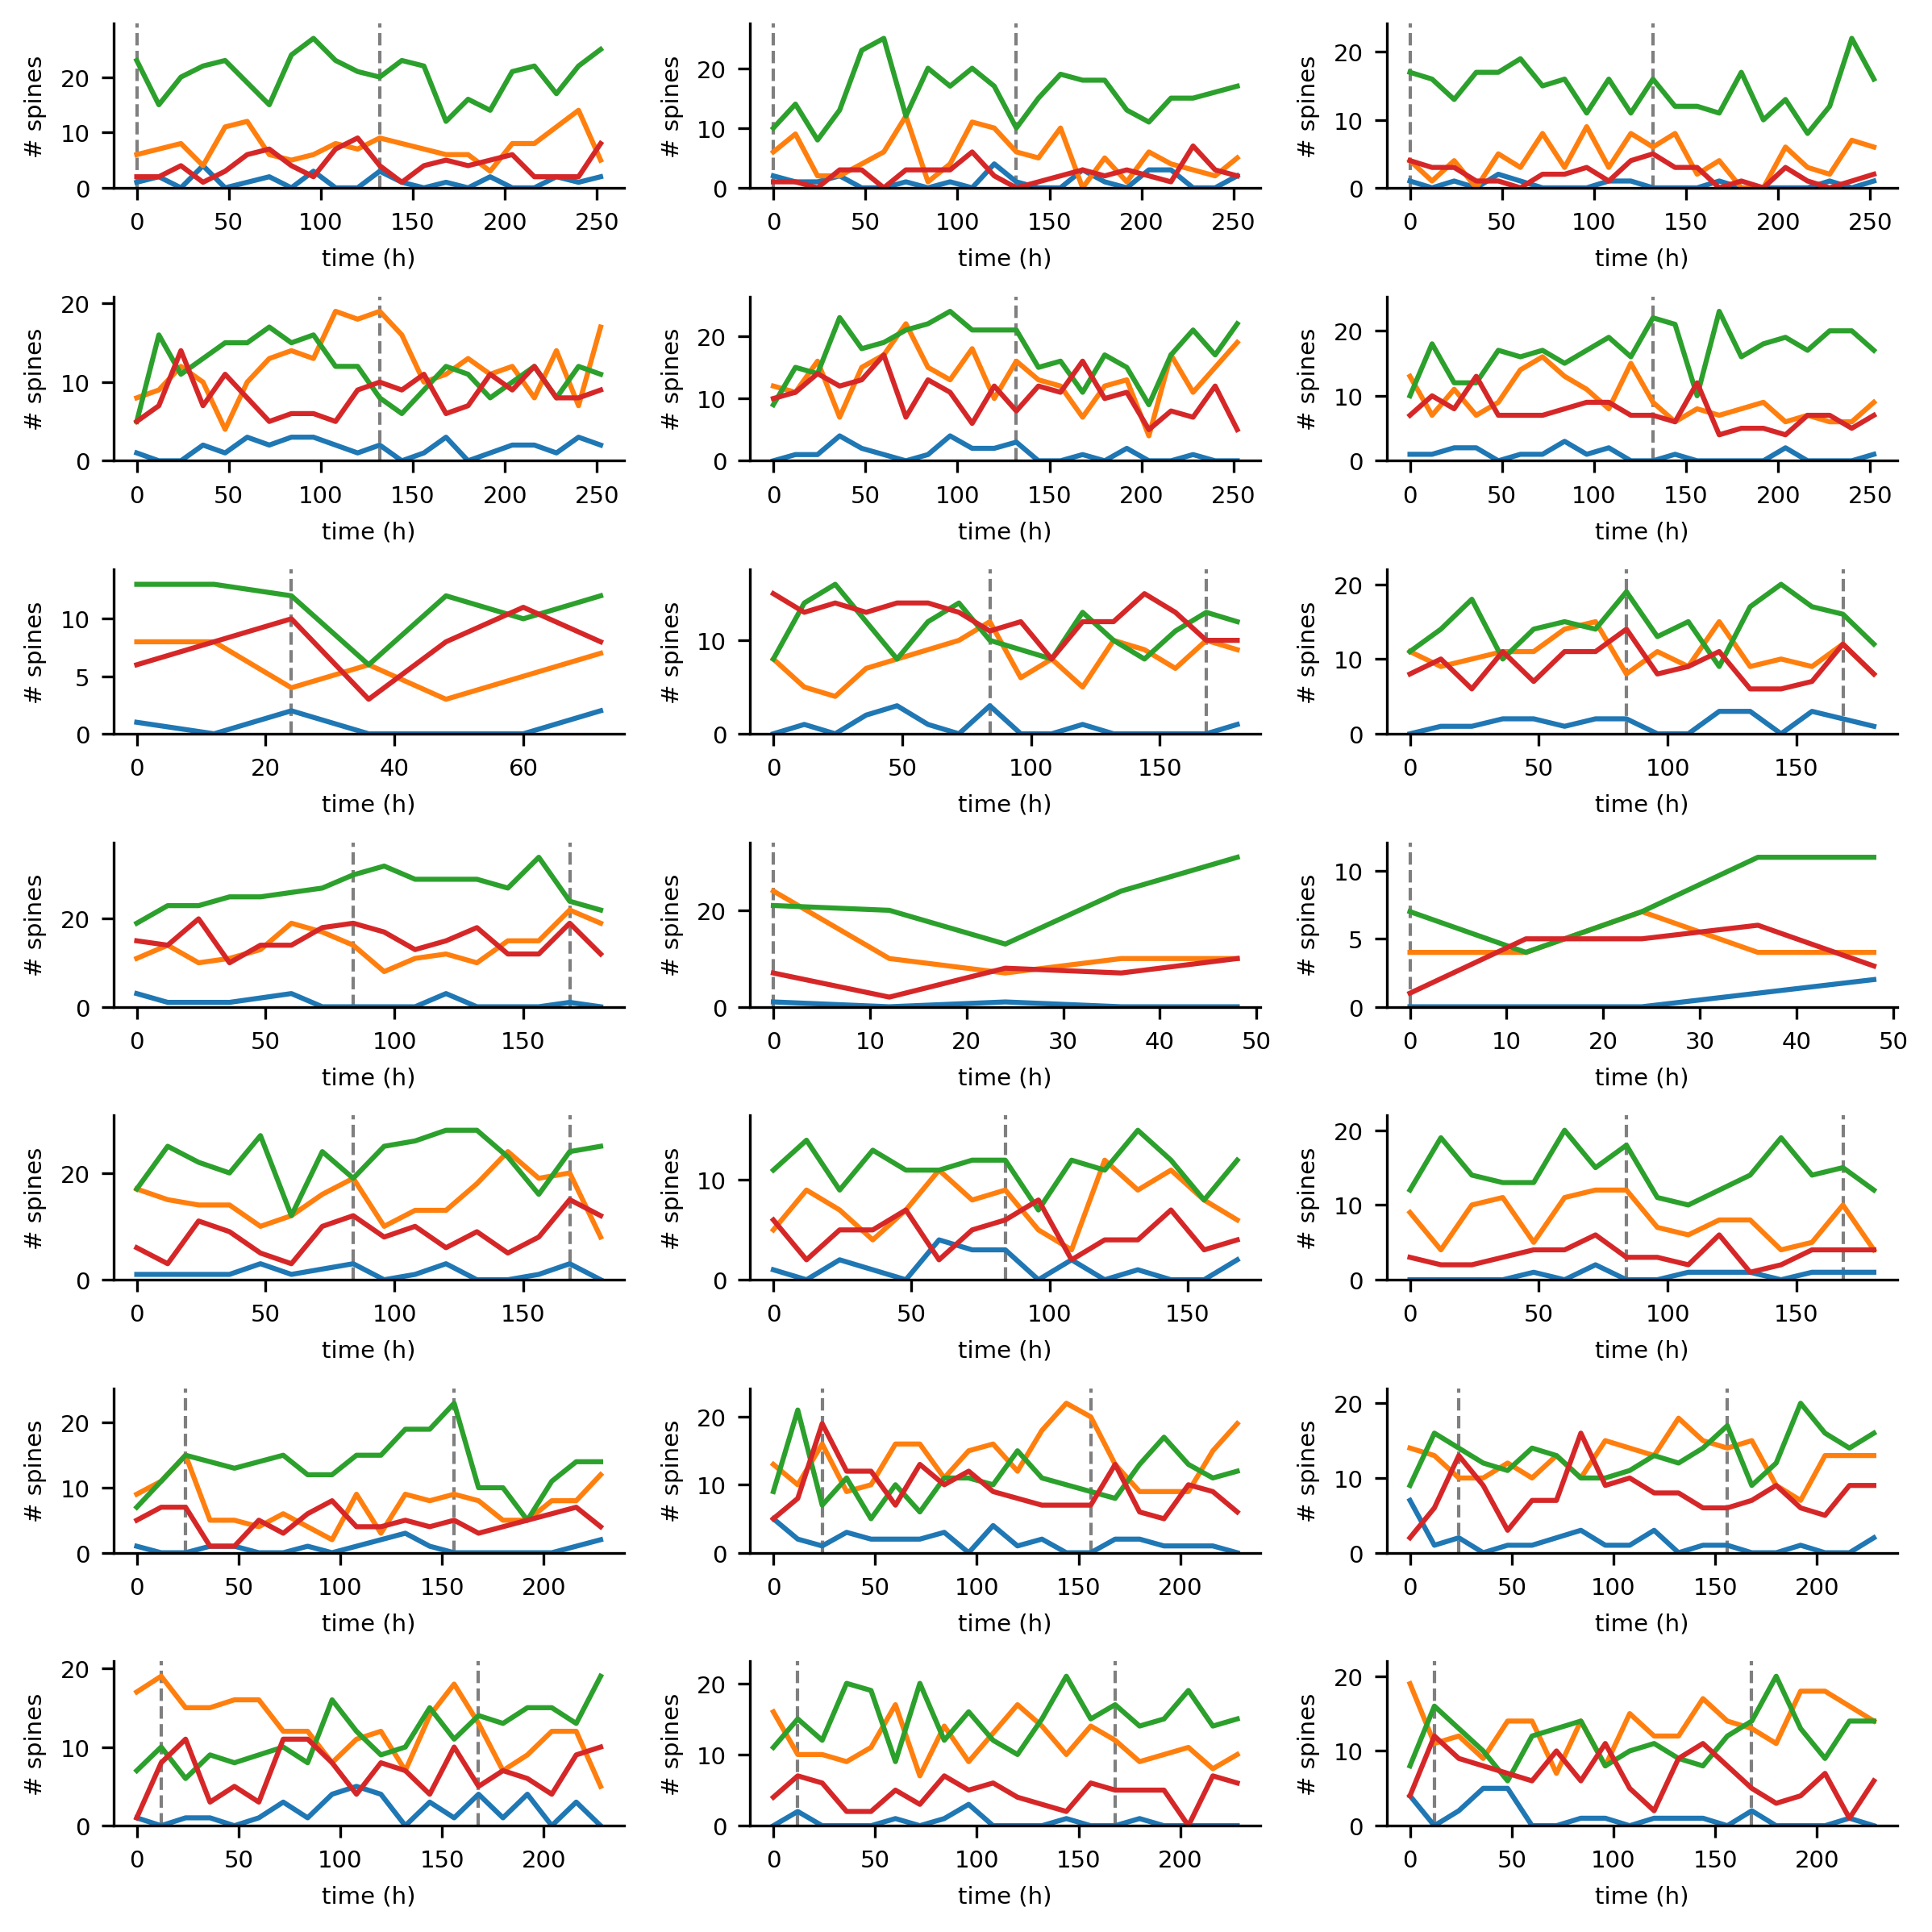

In [87]:
fig, axs = plt.subplots(7,3, dpi=300, figsize=(8,8))
axs = axs.flatten()

for i, file_path in enumerate(file_paths):

    ax = axs[i]

    df = pd.read_hdf(os.path.join('clean_data', file_path))
    df = df.replace('filopodia', 'filopodium')

    for j in range(0, len(df)-1):
        if df.iloc[j]['stage'] == 'P' and df.iloc[j+1]['stage'] == 'E':
            ax.vlines(j*12, 0, 100, color='tab:grey', lw=1, ls='--')

    row_value_counts = []
    for index, row in df.iterrows():
        row_value_counts.append(row.value_counts())
    counts = pd.DataFrame(row_value_counts).fillna(0)
    counts = counts[['filopodium','thin','stubby','mushroom']]

    t_ = np.arange(0, len(counts['filopodium'].to_numpy()))*12
    ax.plot(t_, counts['filopodium'].to_numpy())
    ax.plot(t_, counts['thin'].to_numpy())
    ax.plot(t_, counts['stubby'].to_numpy())
    ax.plot(t_, counts['mushroom'].to_numpy())
    ax.set_ylim([0,np.max(counts)*1.1])
    # ax.set_xlim([-1,(len(counts)-1)*12])
    ax.set_ylabel('# spines')
    ax.set_xlabel('time (h)')
fig.tight_layout()
fig.savefig('spine_examples.svg')

In [99]:
pd.read_hdf(os.path.join('clean_data', file_paths[0])).iloc[0].value_counts()

0
stubby       23
NS           17
thin          6
mushroom      2
filopodia     1
0             1
P             1
Name: count, dtype: int64

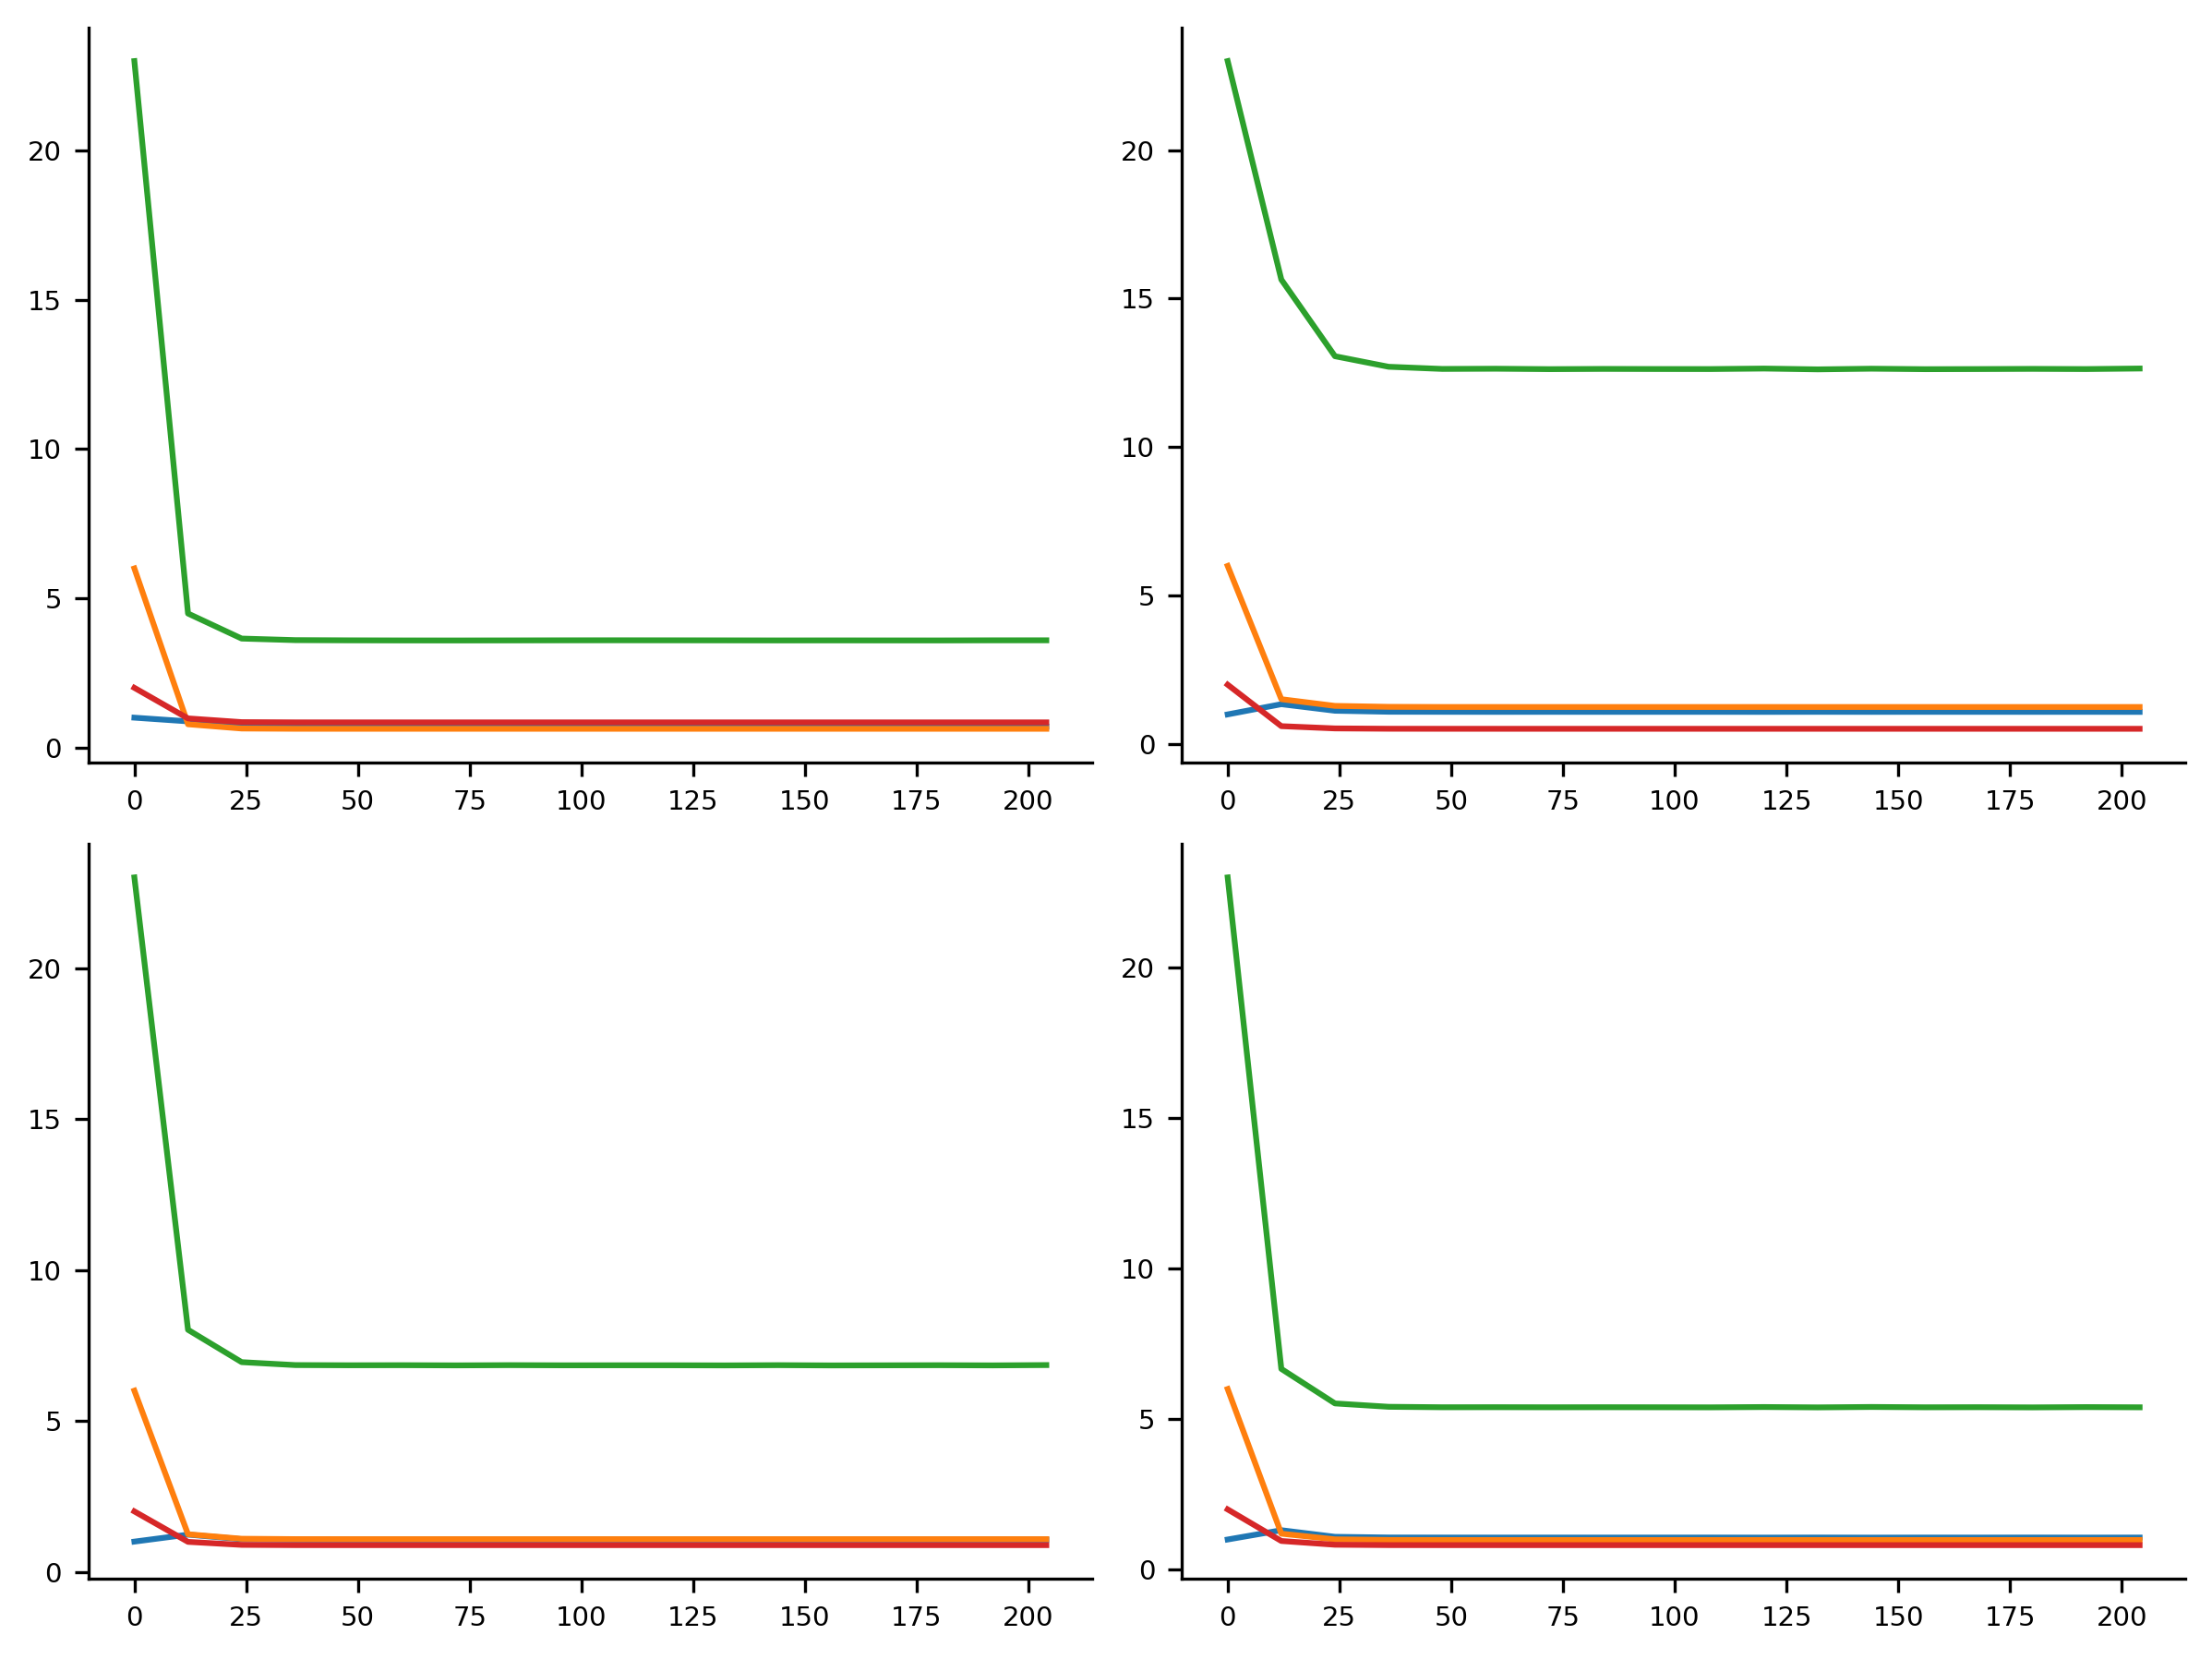

In [108]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2, 2, dpi=300, figsize=(8,6))

sol = simulate_system(DtoP, y0=[1,6,23,2], t_steps=18)
ax1.plot(sol.t, sol.y[0])
ax1.plot(sol.t, sol.y[1])
ax1.plot(sol.t, sol.y[2])
ax1.plot(sol.t, sol.y[3])

sol = simulate_system(PtoE, y0=[1,6,23,2], t_steps=18)
ax2.plot(sol.t, sol.y[0])
ax2.plot(sol.t, sol.y[1])
ax2.plot(sol.t, sol.y[2])
ax2.plot(sol.t, sol.y[3])

sol = simulate_system(EtoM, y0=[1,6,23,2], t_steps=18)
ax3.plot(sol.t, sol.y[0])
ax3.plot(sol.t, sol.y[1])
ax3.plot(sol.t, sol.y[2])
ax3.plot(sol.t, sol.y[3])

sol = simulate_system(MtoD, y0=[1,6,23,2], t_steps=18)
ax4.plot(sol.t, sol.y[0])
ax4.plot(sol.t, sol.y[1])
ax4.plot(sol.t, sol.y[2])
ax4.plot(sol.t, sol.y[3])

fig.tight_layout()

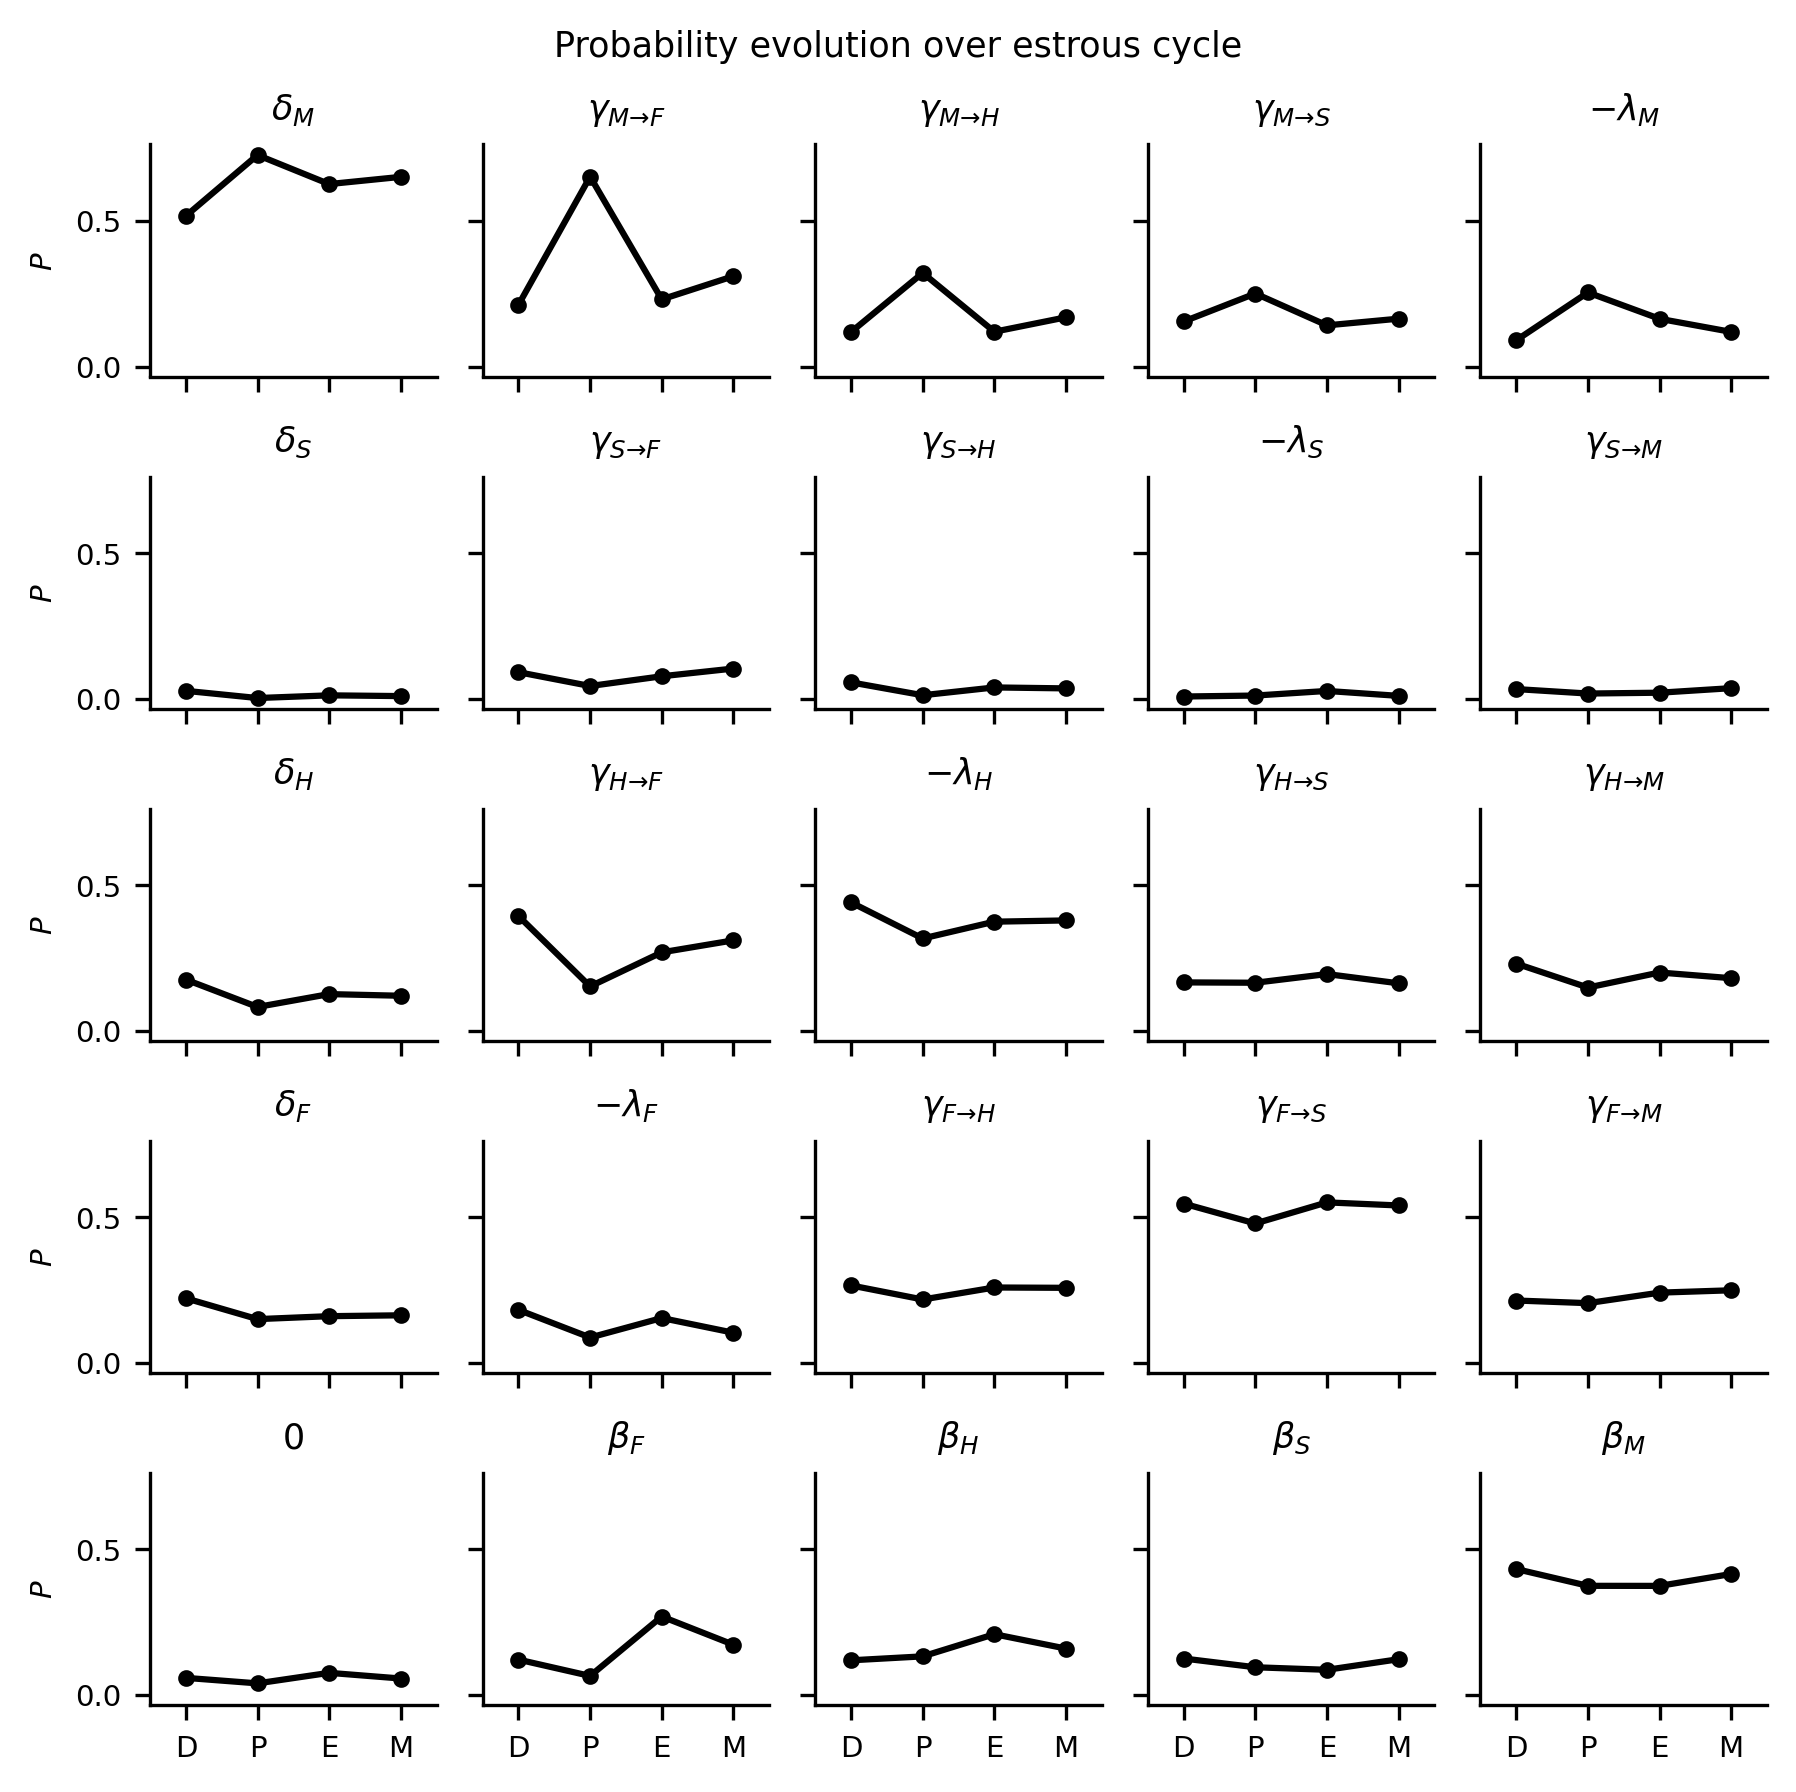

In [25]:
def plot_matrix_cell_evolution(matrices, ffit=None):
    """
    Plot the evolution of each cell in a series of 5x5 matrices over time.
    
    Parameters:
    matrices (list of np.ndarray): A list of four 5x5 numpy arrays representing values at four timepoints.
    """
    assert len(matrices) == 4, "Input must be a list of four 5x5 matrices"
    for mat in matrices:
        assert mat.shape == (5, 5), "All matrices must be 5x5"

    fig, axes = plt.subplots(5, 5, figsize=(6,6), dpi=300, sharex=True, sharey=True)
    fig.suptitle("Probability evolution over estrous cycle")

    timepoints = np.arange(4)
    timepoints_f = np.arange(0,3.2,0.2)

    symbol_matrix = np.array([
        [r'$\delta_M$', r'$\gamma_{M \to F}$', r'$\gamma_{M \to H}$', r'$\gamma_{M \to S}$', r'$-\lambda_M$'],
        [r'$\delta_S$', r'$\gamma_{S \to F}$', r'$\gamma_{S \to H}$', r'$-\lambda_S$', r'$\gamma_{S \to M}$'],
        [r'$\delta_H$', r'$\gamma_{H \to F}$', r'$-\lambda_H$', r'$\gamma_{H \to S}$', r'$\gamma_{H \to M}$'],
        [r'$\delta_F$', r'$-\lambda_F$', r'$\gamma_{F \to H}$', r'$\gamma_{F \to S}$', r'$\gamma_{F \to M}$'],
        [r'$0$', r'$\beta_F$', r'$\beta_H$', r'$\beta_S$', r'$\beta_M$']
    ])

    for i in range(5):
        for j in range(5):
            values = [mat[i, j] for mat in matrices]
            ax = axes[i, j]
            ax.plot(timepoints, values, marker='.', color='k')
            if ffit is not None:
                fit_over_finer_grid = np.interp(timepoints_f, np.arange(4), ffit[:, i, j])
                ax.plot(timepoints_f, fit_over_finer_grid, marker='x', color='tab:orange')
            ax.set_title(symbol_matrix[i,j])
            if j == 0:
                ax.set_ylabel('$P$')
            ax.set_xticks(range(4), labels=['D','P','E','M'])
            ax.set_xlim([-0.5,3.5])
    plt.tight_layout()
    plt.show()
    fig.savefig('probability_evolution_by_stage_stepwise.svg')
plot_matrix_cell_evolution([DtoP,PtoE,EtoM,MtoD])

In [30]:
x_data = np.array([0, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4])
y_data = np.array([10, 20, 25, 40, 10, 5, 10, 5, 10])
estradiol_level = np.interp(np.linspace(0,4,100)*24, x_data*24, y_data)
timepoints_f = np.linspace(0,4,100)*24
spline_interp = scipy.interpolate.CubicSpline(x_data*24, y_data, bc_type="periodic")
estradiol_level_spline = spline_interp(np.linspace(0,4,100)*24)

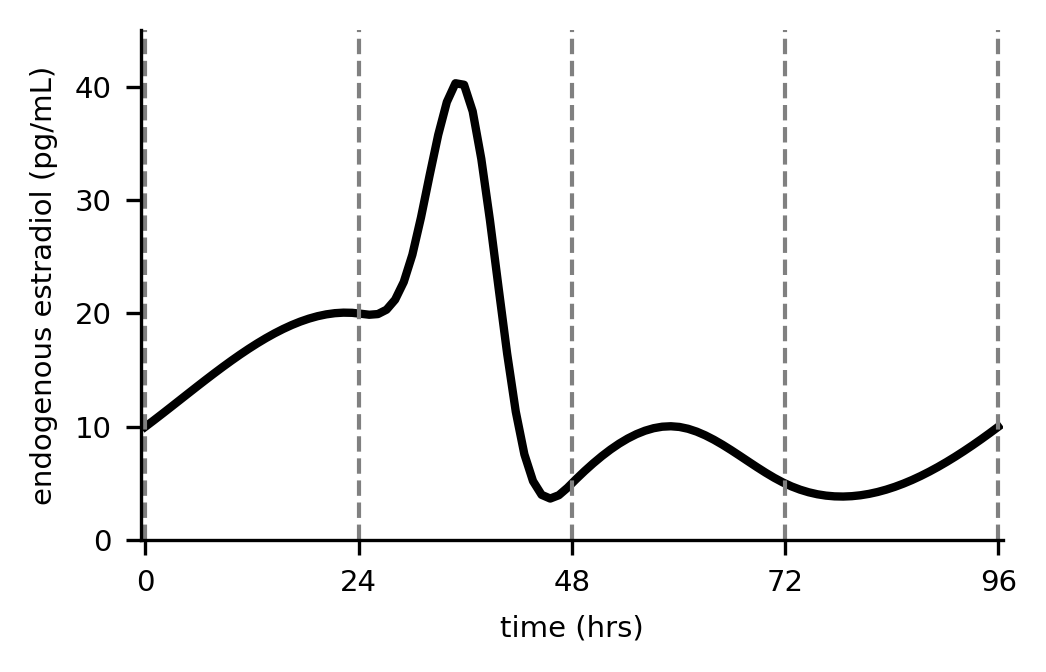

In [67]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(3.5,2.25))
# ax.plot(timepoints_f, estradiol_level)
ax.plot(timepoints_f, estradiol_level_spline, color='k', lw=2)
ax.vlines(np.arange(0,96+24,24), 0, 45, ls='--', lw=1, color='grey')
ax.set_xlim([-0.5,96.5])
ax.set_ylim([0,45])
ax.set_xlabel('time (hrs)')
ax.set_ylabel('endogenous estradiol (pg/mL)')
ax.set_xticks(np.arange(0,96+24,24))
fig.tight_layout()
fig.savefig('estradiol_conc.svg')


C:\Users\dmartins\AppData\Local\Temp\ipykernel_29300\3295910013.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  new_colors = cm.get_cmap('hsv')(np.linspace(0, 1, num_values))
C:\Users\dmartins\AppData\Local\Temp\ipykernel_29300\3295910013.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


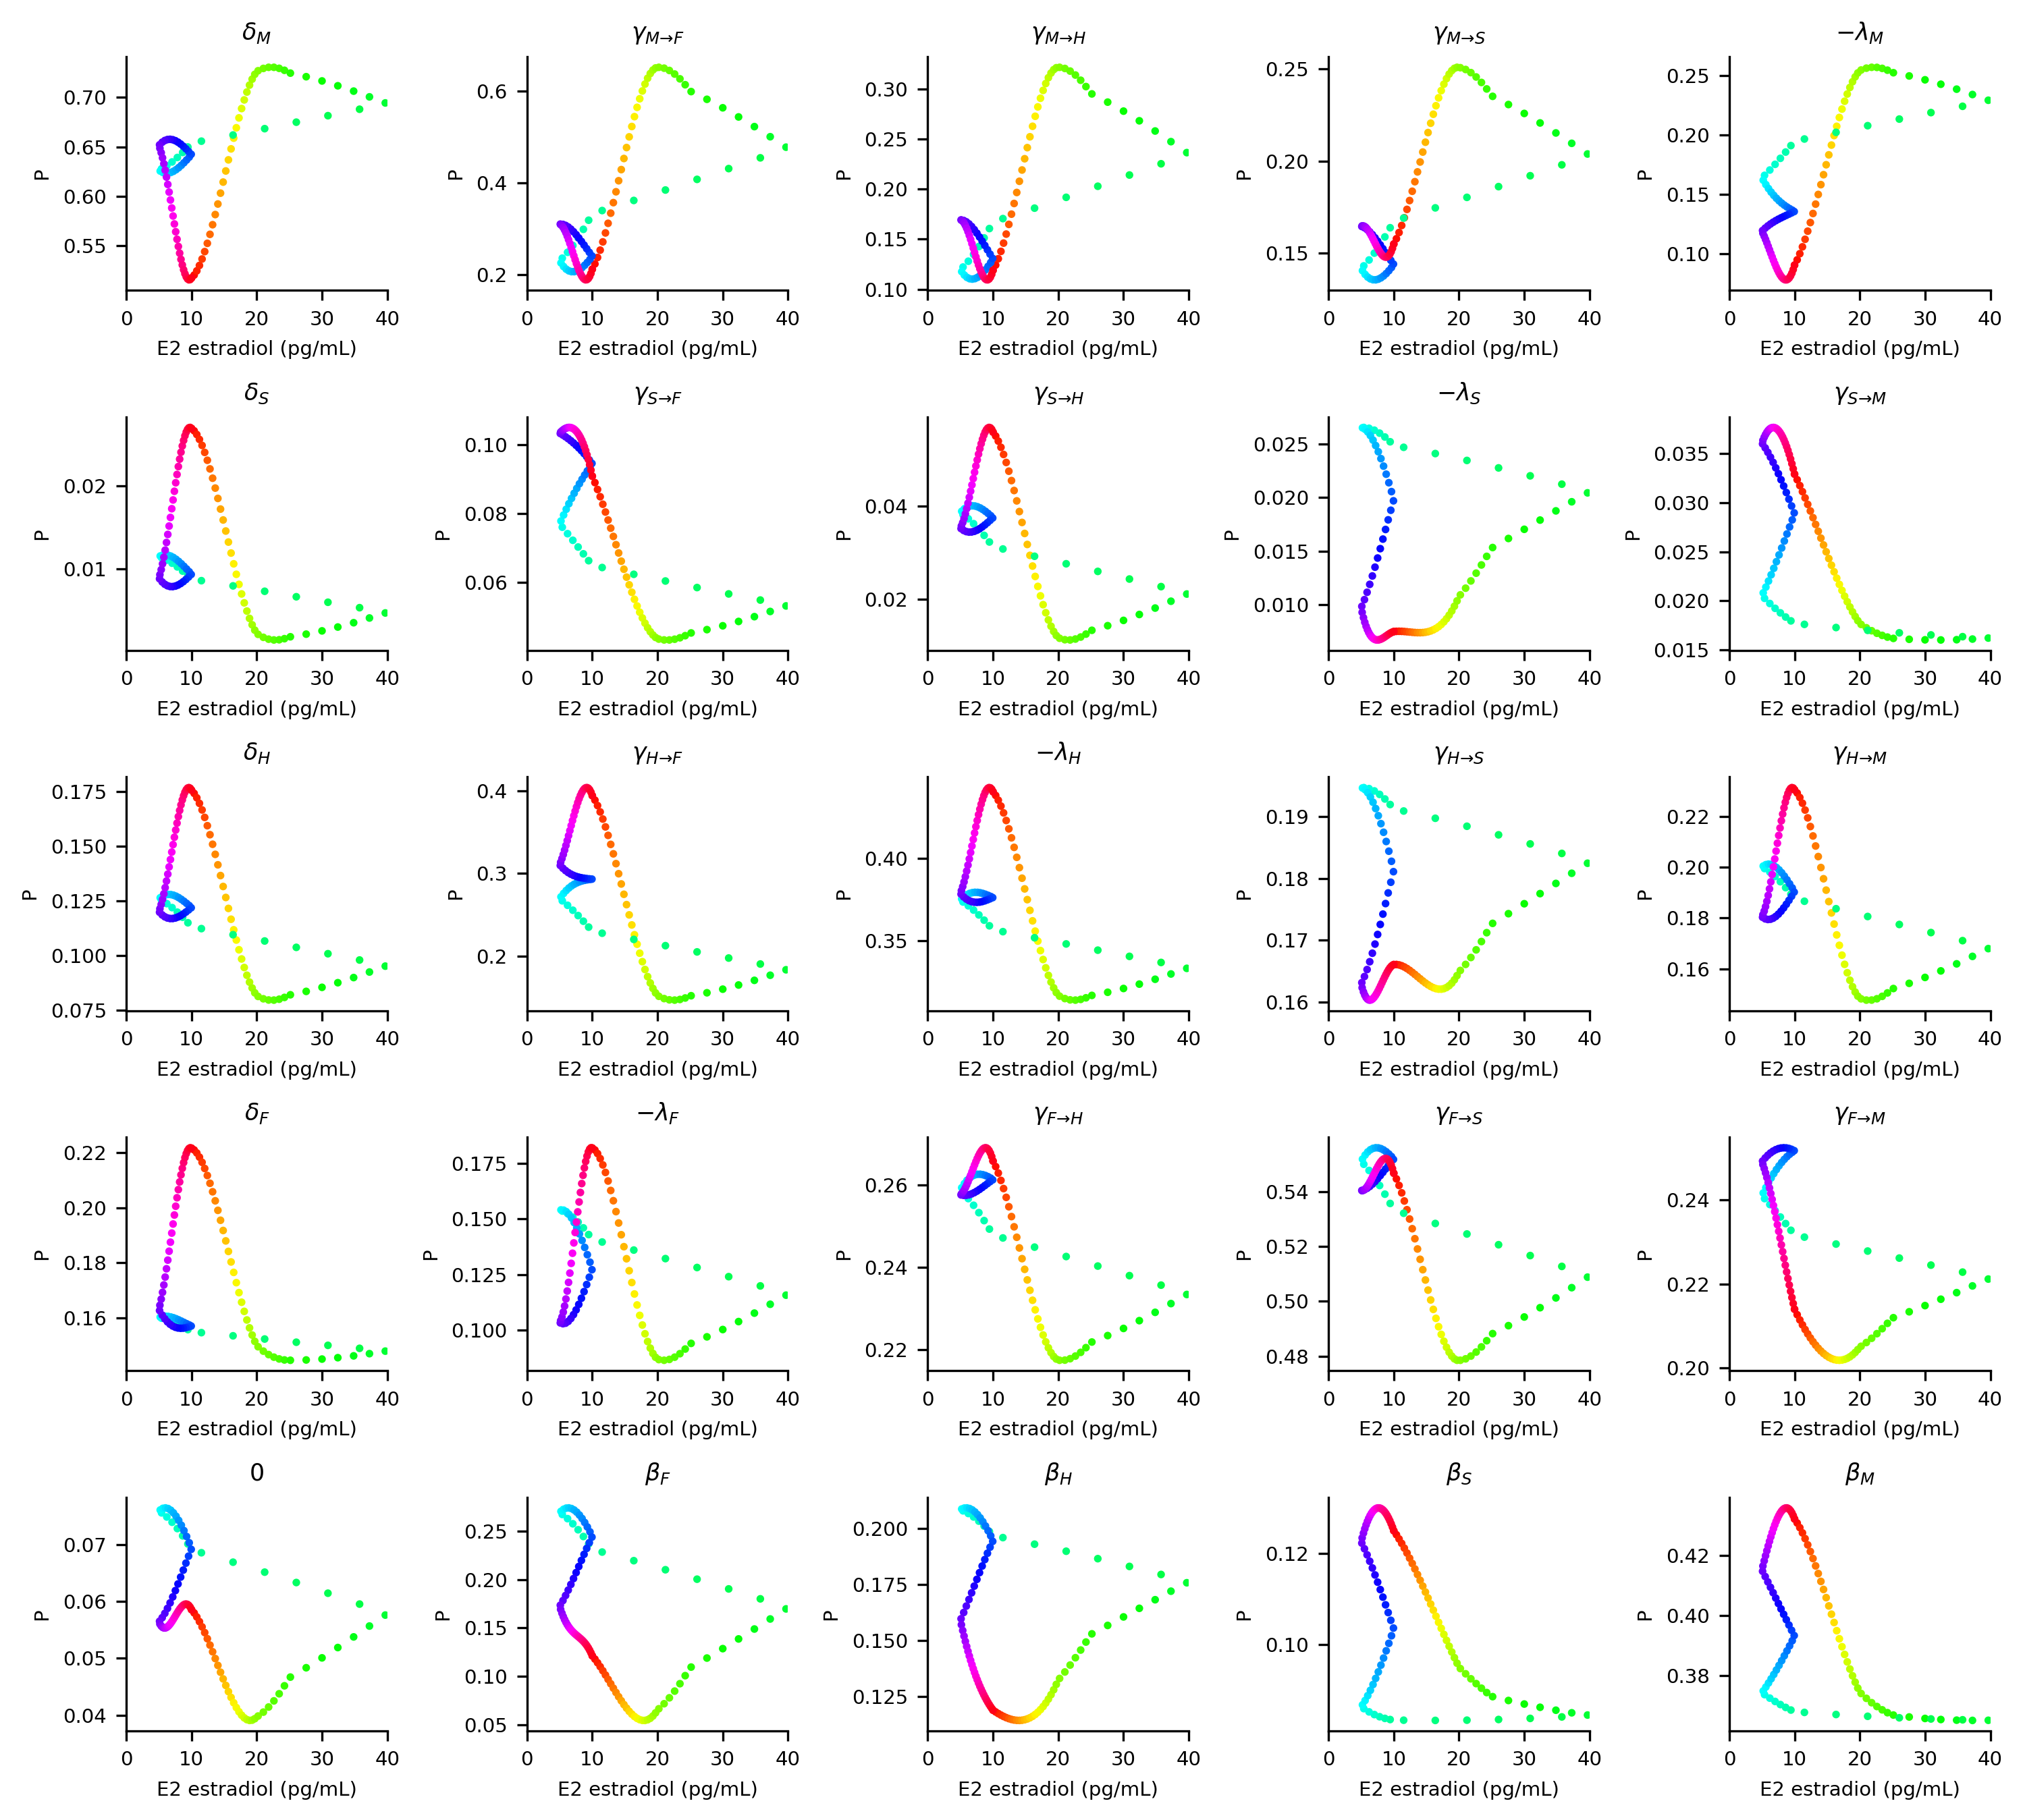

In [20]:
def plot_transition_vs_E2(matrices):

    num_values = 100

    assert len(matrices) == 4, "Input must be a list of four 5x5 matrices"
    for mat in matrices:
        assert mat.shape == (5, 5), "All matrices must be 5x5"

    fig, axes = plt.subplots(5, 5, figsize=(10,9), dpi=300)#, sharex=True, sharey=True)
    # fig.suptitle("Probability evolution over estrous cycle")

    x_data = np.array([0, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4])
    y_data = np.array([10, 20, 25, 40, 10, 5, 10, 5, 10])
    estradiol_level = np.interp(np.linspace(0,4,num_values)*24, x_data*24, y_data)
    timepoints_f = np.linspace(0,4,num_values)*24

    symbol_matrix = np.array([
        [r'$\delta_M$', r'$\gamma_{M \to F}$', r'$\gamma_{M \to H}$', r'$\gamma_{M \to S}$', r'$-\lambda_M$'],
        [r'$\delta_S$', r'$\gamma_{S \to F}$', r'$\gamma_{S \to H}$', r'$-\lambda_S$', r'$\gamma_{S \to M}$'],
        [r'$\delta_H$', r'$\gamma_{H \to F}$', r'$-\lambda_H$', r'$\gamma_{H \to S}$', r'$\gamma_{H \to M}$'],
        [r'$\delta_F$', r'$-\lambda_F$', r'$\gamma_{F \to H}$', r'$\gamma_{F \to S}$', r'$\gamma_{F \to M}$'],
        [r'$0$', r'$\beta_F$', r'$\beta_H$', r'$\beta_S$', r'$\beta_M$']
    ])
    
    new_colors = cm.get_cmap('hsv')(np.linspace(0, 1, num_values))

    for i in range(5):
        for j in range(5):
            values = [mat[i, j] for mat in matrices]
            ax = axes[i,j]

            # linear interpolation
            # fit_over_finer_grid = np.interp(timepoints_f, np.arange(4)*24, values)

            # circular interpolation
            x_ = np.arange(5)*24
            y_ = np.append(values, values[0])
            spline_interp = scipy.interpolate.CubicSpline(x_, y_, bc_type="periodic")
            fit_over_finer_grid = spline_interp(timepoints_f)

            # if i==0 and j==0:
            #     print(timepoints_f, fit_over_finer_grid)
            ax.scatter(estradiol_level[np.arange(num_values)], fit_over_finer_grid, s=3, color=new_colors)
            # ax.plot(timepoints, values, marker='.', color='k')
            ax.set_title(symbol_matrix[i,j])
            # if j == 0:
                # ax.set_ylabel('$P$')
            # ax.set_xticks(range(4), labels=['D','P','E','M'])
            ax.set_xlim([0,40])
            ax.set_xticks(np.arange(0,50,10))
            ax.set_xlabel('E2 estradiol (pg/mL)')
            ax.set_ylabel('P')

    fig.tight_layout()
    fig.show()
    fig.savefig('probability_evolution_vs_estrous_stage.svg')


plot_transition_vs_E2([DtoP,PtoE,EtoM,MtoD])


In [ ]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4,4))
# new_colors = cm.get_cmap('hsv')(np.linspace(0, 4, 100))
sm = plt.cm.ScalarMappable()
sm.set_cmap('hsv')
sm.set_clim(vmin=0, vmax=96)
sm.set_xticks(np.arange(0,96,24))
cbar = fig.colorbar(sm)
# fig.savefig('estrous_stage_cbar.svg')

SyntaxError: '(' was never closed (3638959835.py, line 6)

In [43]:
x_data = np.array([0, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4])
y_data = np.array([10, 20, 25, 40, 10, 5, 10, 5, 10])
estradiol_level = np.interp(np.linspace(0,4,100)*24, x_data*24, y_data)